# Análisis de Susceptibilidad de Deslizamientos - Taltal, Chile

Este notebook replica el análisis realizado en R (`datos_aumentados_taltal.R`) usando MLPY y librerías de Python.

## Flujo de trabajo:
1. **Fase 1**: Procesamiento geoespacial (delegado a librerías especializadas)
2. **Fase 2**: Extracción de características del terreno
3. **Fase 3**: Machine Learning espacial con MLPY
4. **Fase 4**: Selección de características
5. **Fase 5**: Benchmarking multi-modelo

## Configuración Inicial

In [ ]:
# Corregir imports si hay conflicto con versión antigua de MLPY
import sys
import os

# Remover rutas de Anaconda que puedan tener versión antigua
anaconda_paths = [p for p in sys.path if 'anaconda3' in p.lower() and 'site-packages' in p]
for path in anaconda_paths:
    sys.path.remove(path)

# IMPORTANTE: Asegurar que MLPY esté disponible sin importar desde dónde se ejecute
# Detectar la ruta del notebook y encontrar MLPY relativamente
current_dir = os.getcwd()
print(f"Ejecutando desde: {current_dir}")

# Buscar MLPY en varias ubicaciones posibles
mlpy_paths = [
    r'C:\Users\gran_\Documents\Proyectos\MLPY',  # Ruta absoluta principal
    os.path.join(current_dir, '..'),  # Un nivel arriba si estás en notebooks/
    os.path.join(current_dir, '../..'),  # Dos niveles arriba
    current_dir  # Directorio actual
]

mlpy_found = False
for path in mlpy_paths:
    if os.path.exists(os.path.join(path, 'mlpy')):
        if path not in sys.path:
            sys.path.insert(0, path)
        MLPY_PATH = path
        mlpy_found = True
        print(f"✓ MLPY encontrado en: {path}")
        break

if not mlpy_found:
    print("⚠️ ADVERTENCIA: MLPY no encontrado automáticamente.")
    print("Por favor, ajusta MLPY_PATH manualmente:")
    MLPY_PATH = input("Ingresa la ruta a la carpeta MLPY: ").strip()
    sys.path.insert(0, MLPY_PATH)

# Verificar que MLPY está disponible
try:
    import mlpy
    print(f"✓ MLPY cargado correctamente desde: {mlpy.__file__}")
    print(f"Versión: {mlpy.__version__ if hasattr(mlpy, '__version__') else 'desarrollo'}")
except ImportError as e:
    print(f"✗ Error al importar MLPY: {e}")
    print("Verifica que la ruta sea correcta y que MLPY esté instalado")

# Verificar componente espacial
try:
    from mlpy.tasks import TaskClassifSpatial
    print("✓ Componentes espaciales disponibles")
except ImportError:
    print("✗ Error: Componentes espaciales no disponibles. Revisa la instalación.")

In [1]:
# Importaciones generales
import numpy as np
import pandas as pd
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Configuración de visualización
sns.set_palette("husl")
%matplotlib inline

# Para trabajar con rasters
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rasterio.features

# Para análisis del terreno
from scipy import ndimage
from skimage import filters

print("Librerías cargadas correctamente")

C:\Users\gran_\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\gran_\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


Librerías cargadas correctamente


## Fase 1: Carga y Procesamiento de Datos Geoespaciales

En el script R, se usan librerías como `terra`, `whitebox` y SAGA-GIS. En Python, usaremos:
- `rasterio` para manejo de rasters
- `geopandas` para datos vectoriales
- `richdem` o `pysheds` para análisis del terreno (opcional)

In [2]:
# Corregir imports si hay conflicto con versión antigua de MLPY
import sys
import os

# Definir rutas de datos
# NOTA: Ajustar estas rutas según tu configuración
DATA_DIR = r"C:\Users\gran_\Documents\Datos\Taltal"  # Cambiar según tu directorio
DEM_PATH = os.path.join(DATA_DIR, "dem_taltal_30m.tif")
LANDSLIDES_PATH = os.path.join(DATA_DIR, "inventario_deslizamientos.shp")
STUDY_AREA_PATH = os.path.join(DATA_DIR, "area_estudio.shp")

# Verificar si los archivos existen (ejemplo)
if os.path.exists(DATA_DIR):
    print(f"Directorio de datos encontrado: {DATA_DIR}")
    files = os.listdir(DATA_DIR)
    print(f"Archivos disponibles: {files[:5]}...")  # Mostrar primeros 5 archivos
else:
    print(f"ADVERTENCIA: Directorio no encontrado. Usando datos de ejemplo.")
    # Crear datos de ejemplo para demostración
    CREATE_EXAMPLE_DATA = True

ADVERTENCIA: Directorio no encontrado. Usando datos de ejemplo.


In [3]:
# Función para calcular derivadas del terreno
def calculate_terrain_derivatives(dem_array, pixel_size=30):
    """
    Calcula las derivadas del terreno desde un DEM.
    Similar a lo que hace terrain() en R o wbt_geomorphons en WhiteboxTools.
    """
    derivatives = {}
    
    # Pendiente (Slope)
    gy, gx = np.gradient(dem_array, pixel_size)
    slope_radians = np.arctan(np.sqrt(gx**2 + gy**2))
    derivatives['slope'] = np.degrees(slope_radians)
    
    # Aspecto (Aspect)
    aspect_radians = np.arctan2(-gx, gy)
    derivatives['aspect'] = np.degrees(aspect_radians) % 360
    
    # Curvatura total
    gxx = ndimage.sobel(gx, axis=1) / pixel_size
    gyy = ndimage.sobel(gy, axis=0) / pixel_size
    derivatives['curvature'] = gxx + gyy
    
    # Curvatura del perfil (Profile Curvature)
    gxy = ndimage.sobel(gx, axis=0) / pixel_size
    derivatives['profile_curvature'] = -2 * (gx**2 * gxx + gy**2 * gyy + gx * gy * gxy) / \
                                       (gx**2 + gy**2 + 1e-10)
    
    # Curvatura del plano (Plan Curvature)
    derivatives['plan_curvature'] = 2 * (gy**2 * gxx - gx * gy * gxy + gx**2 * gyy) / \
                                    ((gx**2 + gy**2) * np.sqrt(1 + gx**2 + gy**2) + 1e-10)
    
    # TRI (Terrain Ruggedness Index)
    kernel = np.ones((3, 3))
    kernel[1, 1] = 0
    neighbors_sum = ndimage.convolve(dem_array, kernel, mode='reflect')
    center_sum = dem_array * 8
    derivatives['tri'] = np.abs(neighbors_sum - center_sum) / 8
    
    # TPI (Topographic Position Index) - ventana de 3x3
    mean_filter = ndimage.uniform_filter(dem_array, size=3, mode='reflect')
    derivatives['tpi'] = dem_array - mean_filter
    
    # TWI (Topographic Wetness Index) - versión simplificada
    # TWI = ln(a/tan(β)) donde a es el área contribuyente y β es la pendiente
    # Aquí usamos una aproximación simple
    flow_acc = np.ones_like(dem_array) * pixel_size**2  # Simplificación
    derivatives['twi'] = np.log((flow_acc + 1) / (np.tan(slope_radians) + 0.001))
    
    return derivatives

print("Función de derivadas del terreno definida")

Función de derivadas del terreno definida


## Fase 2: Crear Dataset de Ejemplo o Cargar Datos Reales

In [4]:
# Crear datos de ejemplo si no hay datos reales
def create_example_landslide_data(n_samples=5000, n_features=20, seed=42):
    """
    Crea un dataset sintético similar al de susceptibilidad de deslizamientos.
    """
    np.random.seed(seed)
    
    # Generar coordenadas (zona UTM 19S aproximada para Taltal)
    x_coords = np.random.uniform(350000, 380000, n_samples)
    y_coords = np.random.uniform(7100000, 7150000, n_samples)
    
    # Generar características del terreno
    elevation = np.random.uniform(0, 3000, n_samples)  # Elevación en metros
    slope = np.random.gamma(2, 10, n_samples)  # Pendiente en grados
    aspect = np.random.uniform(0, 360, n_samples)  # Aspecto
    
    # Curvaturas
    curvature = np.random.normal(0, 0.1, n_samples)
    profile_curv = np.random.normal(0, 0.05, n_samples)
    plan_curv = np.random.normal(0, 0.05, n_samples)
    
    # Índices topográficos
    tri = np.random.gamma(1.5, 5, n_samples)  # Terrain Ruggedness
    tpi = np.random.normal(0, 10, n_samples)  # Topographic Position
    twi = np.random.normal(7, 2, n_samples)  # Wetness Index
    
    # Características geológicas (categóricas convertidas a dummies)
    lithology = np.random.choice(['sedimentary', 'igneous', 'metamorphic'], n_samples)
    fault_distance = np.random.exponential(1000, n_samples)  # Distancia a fallas
    
    # Características climáticas
    precipitation = np.random.gamma(2, 50, n_samples)  # Precipitación anual mm
    temperature = 20 - elevation/200 + np.random.normal(0, 2, n_samples)  # Temperatura
    
    # Índices de vegetación (simulados)
    ndvi = np.random.beta(2, 5, n_samples)  # NDVI normalizado [0,1]
    evi = ndvi * 0.8 + np.random.normal(0, 0.05, n_samples)
    
    # Variable objetivo: presencia de deslizamiento (binaria)
    # Modelo logístico con relaciones realistas
    logit = (
        -5 +  # Intercepto
        0.08 * slope +  # Mayor pendiente = mayor probabilidad
        -0.001 * elevation +  # Elevación media más susceptible
        0.5 * (lithology == 'sedimentary') +  # Rocas sedimentarias más susceptibles
        -0.0005 * fault_distance +  # Cerca de fallas = mayor riesgo
        0.01 * precipitation +  # Más lluvia = mayor riesgo
        -2 * ndvi +  # Menos vegetación = mayor riesgo
        0.1 * tri +  # Terreno más rugoso = mayor riesgo
        np.random.normal(0, 0.5, n_samples)  # Ruido
    )
    prob = 1 / (1 + np.exp(-logit))
    landslide = (prob > 0.3).astype(int)  # Umbral para clase positiva
    
    # Crear DataFrame
    data = pd.DataFrame({
        'x': x_coords,
        'y': y_coords,
        'elevation': elevation,
        'slope': slope,
        'aspect': aspect,
        'curvature': curvature,
        'profile_curv': profile_curv,
        'plan_curv': plan_curv,
        'tri': tri,
        'tpi': tpi,
        'twi': twi,
        'lithology': lithology,
        'fault_distance': fault_distance,
        'precipitation': precipitation,
        'temperature': temperature,
        'ndvi': ndvi,
        'evi': evi,
        'landslide': landslide
    })
    
    # Convertir lithology a dummies
    lithology_dummies = pd.get_dummies(data['lithology'], prefix='lithology')
    data = pd.concat([data.drop('lithology', axis=1), lithology_dummies], axis=1)
    
    return data

# Crear o cargar datos
print("Creando dataset de ejemplo...")
df_landslides = create_example_landslide_data(n_samples=5000)
print(f"Dataset creado: {df_landslides.shape}")
print(f"Balance de clases: {df_landslides['landslide'].value_counts().to_dict()}")
print(f"\nPrimeras columnas: {list(df_landslides.columns[:10])}")

Creando dataset de ejemplo...
Dataset creado: (5000, 20)
Balance de clases: {0: 4717, 1: 283}

Primeras columnas: ['x', 'y', 'elevation', 'slope', 'aspect', 'curvature', 'profile_curv', 'plan_curv', 'tri', 'tpi']


## Fase 3: Machine Learning Espacial con MLPY

In [5]:
# Implementación de TaskClassifSpatial
from typing import Optional, List, Tuple, Dict, Any, Union
import numpy as np
import pandas as pd
import warnings

class TaskSpatial:
    """Base class for spatial tasks."""
    
    def __init__(
        self,
        coordinate_names: List[str],
        crs: str = 'EPSG:4326'
    ):
        self.coordinate_names = coordinate_names
        self.crs = crs
        self._coordinates = None
        self._spatial_extent = None
    
    def coordinates(self) -> np.ndarray:
        """Get coordinates as numpy array."""
        if self._coordinates is None:
            self._coordinates = self.data[self.coordinate_names].values
        return self._coordinates
    
    @property
    def spatial_extent(self) -> Dict[str, float]:
        """Get spatial extent of the data."""
        if self._spatial_extent is None:
            coords = self.coordinates()
            self._spatial_extent = {
                'xmin': coords[:, 0].min(),
                'xmax': coords[:, 0].max(),
                'ymin': coords[:, 1].min(),
                'ymax': coords[:, 1].max()
            }
        return self._spatial_extent

class TaskClassifSpatial(TaskSpatial):
    """
    Spatial classification task.
    
    Parameters
    ----------
    data : pd.DataFrame
        The data
    target : str
        Target column name
    coordinate_names : List[str]
        Names of coordinate columns (e.g., ['x', 'y'])
    crs : str
        Coordinate Reference System (default: 'EPSG:4326')
    id : str
        Task identifier
    """
    
    def __init__(
        self,
        data: pd.DataFrame,
        target: str,
        coordinate_names: List[str],
        crs: str = 'EPSG:4326',
        id: str = 'spatial_classif'
    ):
        super().__init__(coordinate_names, crs)
        self.data = data
        self.target = target
        self.id = id
        self.task_type = 'classification'
        
        # Propiedades básicas
        self.nrow = len(data)
        self.ncol = len(data.columns)
        self.feature_names = [col for col in data.columns 
                             if col != target and col not in coordinate_names]
    
    def get_data(self, rows=None, cols=None):
        """Get subset of data."""
        df = self.data
        if rows is not None:
            df = df.iloc[rows]
        if cols is not None:
            df = df[cols]
        return df

print("✓ TaskClassifSpatial implementada")

✓ TaskClassifSpatial implementada


In [ ]:
# Solución alternativa: usar los modelos directamente con learner_sklearn
# Esto funciona porque learner_sklearn puede envolver cualquier estimador de sklearn-compatible

# Verificar disponibilidad real de las librerías
xgboost_available = False
lightgbm_available = False
catboost_available = False

try:
    import xgboost as xgb
    xgboost_available = True
    print(f"✓ XGBoost {xgb.__version__} está instalado y disponible")
except ImportError:
    print("✗ XGBoost no está disponible")

try:
    import lightgbm as lgb
    lightgbm_available = True
    print(f"✓ LightGBM {lgb.__version__} está instalado y disponible")
except ImportError:
    print("✗ LightGBM no está disponible")

try:
    import catboost as cb
    catboost_available = True
    print(f"✓ CatBoost {cb.__version__} está instalado y disponible")
except ImportError:
    print("✗ CatBoost no está disponible")

# Si están disponibles, agregarlos usando learner_sklearn
if xgboost_available:
    from xgboost import XGBClassifier
    learners.append(
        learner_sklearn(
            XGBClassifier(
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                objective='binary:logistic',
                random_state=42,
                eval_metric='logloss'
            ),
            id='xgboost'
        )
    )
    print("→ XGBoost agregado al benchmark")

if lightgbm_available:
    from lightgbm import LGBMClassifier
    learners.append(
        learner_sklearn(
            LGBMClassifier(
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                objective='binary',
                random_state=42,
                verbose=-1
            ),
            id='lightgbm'
        )
    )
    print("→ LightGBM agregado al benchmark")

if catboost_available:
    from catboost import CatBoostClassifier
    learners.append(
        learner_sklearn(
            CatBoostClassifier(
                iterations=100,
                depth=6,
                learning_rate=0.1,
                loss_function='Logloss',
                random_state=42,
                verbose=False
            ),
            id='catboost'
        )
    )
    print("→ CatBoost agregado al benchmark")

print(f"\n✅ Total de modelos en el benchmark: {len(learners)}")
print(f"Modelos disponibles: {[l.id for l in learners]}")

### 🔧 Solución alternativa para XGBoost, LightGBM y CatBoost

Si los wrappers de MLPY no detectan las librerías, usaremos wrappers directos con sklearn:

## 🔧 Implementación Completa de Clases Espaciales

A continuación incluimos la implementación completa de las clases de validación cruzada espacial para que puedas ver exactamente cómo funcionan y ejecutarlas directamente en este notebook.

In [6]:
# Importar componentes de MLPY
from mlpy.tasks import TaskClassifSpatial
from mlpy.resamplings import SpatialKFold, SpatialBlockCV, SpatialBufferCV
from mlpy.learners import learner_sklearn
from mlpy.learners import learner_xgboost, learner_lightgbm, learner_catboost
from mlpy.measures import create_measure
from mlpy.benchmark_advanced import benchmark_grid, benchmark, compare_learners

print("Componentes MLPY importados")

Componentes MLPY importados


In [7]:
# Crear tarea espacial de clasificación
task_spatial = TaskClassifSpatial(
    data=df_landslides,
    target='landslide',
    coordinate_names=['x', 'y'],  # Cambiado de 'coords' a 'coordinate_names'
    crs='EPSG:32719',  # UTM Zone 19S para Taltal
    id='landslide_susceptibility_taltal'
)

print(f"Tarea espacial creada: {task_spatial.id}")
print(f"Dimensiones: {task_spatial.nrow} filas, {task_spatial.ncol} columnas")
print(f"Features: {len(task_spatial.feature_names)} características")
print(f"CRS: {task_spatial.crs}")
print(f"Extensión espacial: {task_spatial.spatial_extent}")

Tarea espacial creada: landslide_susceptibility_taltal
Dimensiones: 5000 filas, 18 columnas
Features: 17 características
CRS: EPSG:32719
Extensión espacial: {'xmin': 350000.34904266096, 'xmax': 379991.5301985839, 'ymin': 7100002.641346615, 'ymax': 7149975.259485425}


## Fase 4: Selección de Características

Implementamos la selección de características usando los métodos disponibles en MLPY.

In [ ]:
from mlpy.filters import (
    MRMR, CMIM, JMI, Relief, ReliefF, 
    CumulativeRanking, quick_feature_selection
)

# Aplicar diferentes métodos de selección de características
print("Aplicando métodos de selección de características...\n")

# 1. MRMR (Minimum Redundancy Maximum Relevance)
# MRMR usa selección incremental - agrega features una por una
mrmr = MRMR(n_features=10)
mrmr_result = mrmr.calculate(task_spatial)
print(f"Top 10 features (MRMR): {mrmr_result.features[:10]}")

# 2. Relief
# Relief calcula scores para TODAS las features, luego seleccionamos
relief = Relief(n_neighbors=10)  # Solo especificamos vecinos
relief_result = relief.calculate(task_spatial)
# Selección posterior de top 10
top_relief = relief_result.select_top_k(10)
print(f"Top 10 features (Relief): {top_relief}")

# 3. CMIM (Conditional Mutual Information Maximization)
# CMIM también usa selección incremental
cmim = CMIM(n_features=10)
cmim_result = cmim.calculate(task_spatial)
print(f"Top 10 features (CMIM): {cmim_result.features[:10]}")

In [ ]:
# Ranking acumulativo (ensemble)
print("\\nAplicando ranking acumulativo (ensemble)...")

# Opción 1: Usar CumulativeRanking con interfaz simple (sin pesos)
from mlpy.filters import CumulativeRanking

# CumulativeRanking usa filters predefinidos o lista de nombres
cumulative = CumulativeRanking(
    filters=['mrmr', 'relief', 'cmim', 'jmi'],  # Solo nombres de filtros
    n_features=15  # Número de features a retener
)

# Calcular el ranking ensemble
ensemble_result = cumulative.calculate(task_spatial)

# Obtener las top 12 features
if hasattr(ensemble_result, 'select_top_k'):
    top_features = ensemble_result.select_top_k(12)
elif hasattr(ensemble_result, 'features'):
    top_features = ensemble_result.features[:12]
else:
    top_features = list(ensemble_result.scores.keys())[:12]

print(f"\\nTop 12 características seleccionadas (ensemble):")
for i, feat in enumerate(top_features, 1):
    score = ensemble_result.scores.get(feat, 0) if hasattr(ensemble_result, 'scores') else 0
    print(f"{i:2d}. {feat:20s} (score: {score:.4f})")

# Crear tarea con características seleccionadas
selected_cols = ['x', 'y'] + top_features + ['landslide']
df_selected = df_landslides[selected_cols].copy()

task_selected = TaskClassifSpatial(
    data=df_selected,
    target='landslide',
    coordinate_names=['x', 'y'],
    crs='EPSG:32719',
    id='landslide_selected_features'
)

print(f"\\nTarea con características seleccionadas: {task_selected.ncol} columnas")

In [8]:
task_selected = TaskClassifSpatial(
    data=df_landslides,
    target='landslide',
    coordinate_names=['x', 'y'],
    crs='EPSG:32719',
    id='landslide_selected_features'
)

In [ ]:
  import sys
  print(f"Python ejecutable: {sys.executable}")
  print(f"Version: {sys.version}")
  print(f"Paths:")
  for p in sys.path[:5]:
      print(f"  - {p}")

  # Verificar si las librerias estan disponibles
  import subprocess
  result = subprocess.run([sys.executable, "-m", "pip", "list"],
                         capture_output=True, text=True)
  if "xgboost" in result.stdout:
      print("\nXGBoost ESTA instalado en este ambiente")
  else:
      print("\nXGBoost NO esta instalado en este ambiente")

In [ ]:
!pip install xgboost

In [ ]:
!pip install lightgbm

In [ ]:
!pip install catboost

## Fase 5: Validación Cruzada Espacial

Implementamos diferentes estrategias de validación cruzada espacial para evitar autocorrelación.

In [ ]:
  from mlpy.learners import (
      learner_xgboost,
      learner_lightgbm,
      learner_catboost,
      learner_sklearn
  )

  # Agregar XGBoost
  try:
      learners.append(
          learner_xgboost(
              n_estimators=100,
              max_depth=6,
              learning_rate=0.1,
              random_state=42,
              id='xgboost'
          )
      )
      print("[OK] XGBoost agregado al benchmark")
  except Exception as e:
      print(f"[ERROR] XGBoost: {e}")

  # Agregar LightGBM
  try:
      learners.append(
          learner_lightgbm(
              n_estimators=100,
              max_depth=6,
              learning_rate=0.1,
              random_state=42,
              verbose=-1,
              id='lightgbm'
          )
      )
      print("[OK] LightGBM agregado al benchmark")
  except Exception as e:
      print(f"[ERROR] LightGBM: {e}")

  # Agregar CatBoost
  try:
      learners.append(
          learner_catboost(
              n_estimators=100,
              depth=6,
              learning_rate=0.1,
              random_state=42,
              verbose=False,
              id='catboost'
          )
      )
      print("[OK] CatBoost agregado al benchmark")
  except Exception as e:
      print(f"[ERROR] CatBoost: {e}")

  print(f"\nTotal de modelos: {len(learners)}")
  print(f"Modelos disponibles: {[l.id for l in learners]}")

In [9]:
# Importar modelos de sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

# Configurar learners
learners = [
    # Modelos baseline
    learner_sklearn(
        LogisticRegression(max_iter=1000, random_state=42),
        id='logistic_regression'
    ),
    
    learner_sklearn(
        DecisionTreeClassifier(max_depth=10, random_state=42),
        id='decision_tree'
    ),
    
    # Ensemble methods
    learner_sklearn(
        RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
        id='random_forest'
    ),
    
    learner_sklearn(
        GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
        id='gradient_boosting'
    ),
    
    learner_sklearn(
        AdaBoostClassifier(n_estimators=50, random_state=42),
        id='adaboost'
    ),
    
    # SVM
    learner_sklearn(
        SVC(kernel='rbf', probability=True, random_state=42),
        id='svm_rbf'
    ),
    
    # Neural Network
    learner_sklearn(
        MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
        id='neural_network'
    ),
]

# Agregar XGBoost - CORREGIDO: importar directamente del wrapper
try:
    from mlpy.learners.xgboost_wrapper import learner_xgboost
    learners.append(
        learner_xgboost(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            objective='binary:logistic',
            id='xgboost'
        )
    )
    print("✓ XGBoost agregado")
except Exception as e:
    print(f"✗ XGBoost no disponible: {e}")

# Agregar LightGBM - CORREGIDO: importar directamente del wrapper
try:
    from mlpy.learners.lightgbm_wrapper import learner_lightgbm
    learners.append(
        learner_lightgbm(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            objective='binary',
            id='lightgbm'
        )
    )
    print("✓ LightGBM agregado")
except Exception as e:
    print(f"✗ LightGBM no disponible: {e}")

# Agregar CatBoost - CORREGIDO: importar directamente del wrapper
try:
    from mlpy.learners.catboost_wrapper import learner_catboost
    learners.append(
        learner_catboost(
            iterations=100,
            depth=6,
            learning_rate=0.1,
            loss_function='Logloss',
            verbose=False,
            id='catboost'
        )
    )
    print("✓ CatBoost agregado")
except Exception as e:
    print(f"✗ CatBoost no disponible: {e}")

print(f"\nTotal de modelos a comparar: {len(learners)}")
print(f"Modelos: {[l.id for l in learners]}")

✓ XGBoost agregado
✓ LightGBM agregado
✓ CatBoost agregado

Total de modelos a comparar: 10
Modelos: ['logistic_regression', 'decision_tree', 'random_forest', 'gradient_boosting', 'adaboost', 'svm_rbf', 'neural_network', 'xgboost', 'lightgbm', 'catboost']


## Fase 6: Benchmark Multi-Modelo

Comparamos múltiples algoritmos de ML usando validación cruzada espacial.

In [ ]:
# Verificar y analizar las estrategias de CV espacial configuradas
print("="*60)
print("ANÁLISIS DE VALIDACIÓN CRUZADA ESPACIAL")
print("="*60)

# 1. Instanciar y analizar Spatial K-Fold
print("\n1️⃣ SPATIAL K-FOLD (Clustering)")
print("-"*40)
spatial_kfold.instantiate(task_selected)
print(f"   Número de folds: {spatial_kfold.iters}")
print(f"   Método: {spatial_kfold.clustering_method}")

fold_sizes_kfold = []
for i in range(spatial_kfold.iters):
    train_idx = spatial_kfold.train_set(i)
    test_idx = spatial_kfold.test_set(i)
    fold_sizes_kfold.append((len(train_idx), len(test_idx)))
    print(f"   Fold {i}: Train={len(train_idx):4d}, Test={len(test_idx):3d} " +
          f"(Train: {len(train_idx)/task_selected.nrow*100:.1f}%, " +
          f"Test: {len(test_idx)/task_selected.nrow*100:.1f}%)")

# 2. Instanciar y analizar Spatial Block CV
print("\n2️⃣ SPATIAL BLOCK CV")
print("-"*40)
spatial_block.instantiate(task_selected)
print(f"   Configuración de grilla: {spatial_block.n_rows}×{spatial_block.n_cols} = " +
      f"{spatial_block.n_rows * spatial_block.n_cols} bloques")
print(f"   Número de folds: {spatial_block.iters}")

fold_sizes_block = []
for i in range(min(spatial_block.iters, 5)):  # Mostrar solo primeros 5
    train_idx = spatial_block.train_set(i)
    test_idx = spatial_block.test_set(i)
    fold_sizes_block.append((len(train_idx), len(test_idx)))
    print(f"   Fold {i}: Train={len(train_idx):4d}, Test={len(test_idx):3d} " +
          f"(Train: {len(train_idx)/task_selected.nrow*100:.1f}%, " +
          f"Test: {len(test_idx)/task_selected.nrow*100:.1f}%)")

# 3. Instanciar y analizar Spatial Buffer CV
print("\n3️⃣ SPATIAL BUFFER CV")
print("-"*40)
spatial_buffer.instantiate(task_selected)
print(f"   Buffer distance: {spatial_buffer.buffer_distance} metros")
print(f"   Test size: {spatial_buffer.test_size} ({spatial_buffer.test_size*100:.0f}%)")
print(f"   Número de folds: {spatial_buffer.iters}")

fold_sizes_buffer = []
buffer_exclusions = []
for i in range(spatial_buffer.iters):
    train_idx = spatial_buffer.train_set(i)
    test_idx = spatial_buffer.test_set(i)
    fold_sizes_buffer.append((len(train_idx), len(test_idx)))
    expected_train = task_selected.nrow - len(test_idx)
    excluded = expected_train - len(train_idx)
    buffer_exclusions.append(excluded)
    print(f"   Fold {i}: Train={len(train_idx):4d}, Test={len(test_idx):3d} " +
          f"(Excluidos por buffer: {excluded:3d} = {excluded/task_selected.nrow*100:.1f}%)")

# Análisis agregado
print("\n" + "="*60)
print("RESUMEN ESTADÍSTICO")
print("="*60)

# Para K-Fold
train_sizes = [s[0] for s in fold_sizes_kfold]
test_sizes = [s[1] for s in fold_sizes_kfold]
print("\n📊 K-Fold Espacial:")
print(f"   Train promedio: {np.mean(train_sizes):.1f} ± {np.std(train_sizes):.1f}")
print(f"   Test promedio:  {np.mean(test_sizes):.1f} ± {np.std(test_sizes):.1f}")

# Para Block CV
train_sizes = [s[0] for s in fold_sizes_block]
test_sizes = [s[1] for s in fold_sizes_block]
print("\n📊 Block CV:")
print(f"   Train promedio: {np.mean(train_sizes):.1f} ± {np.std(train_sizes):.1f}")
print(f"   Test promedio:  {np.mean(test_sizes):.1f} ± {np.std(test_sizes):.1f}")

# Para Buffer CV
train_sizes = [s[0] for s in fold_sizes_buffer]
test_sizes = [s[1] for s in fold_sizes_buffer]
print("\n📊 Buffer CV:")
print(f"   Train promedio: {np.mean(train_sizes):.1f} ± {np.std(train_sizes):.1f}")
print(f"   Test promedio:  {np.mean(test_sizes):.1f} ± {np.std(test_sizes):.1f}")
print(f"   Excluidos promedio: {np.mean(buffer_exclusions):.1f} ± {np.std(buffer_exclusions):.1f}")
print(f"   % Excluido por buffer: {np.mean(buffer_exclusions)/task_selected.nrow*100:.1f}%")

print("\n✅ Todas las estrategias de CV espacial funcionan correctamente!")

## 🧪 Verificación y Análisis de Validación Cruzada Espacial

Ejecutemos las estrategias de CV espacial y analicemos sus resultados:

In [ ]:
# Importar modelos de sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

# Configurar learners
learners = [
    # Modelos baseline
    learner_sklearn(
        LogisticRegression(max_iter=1000, random_state=42),
        id='logistic_regression'
    ),
    
    learner_sklearn(
        DecisionTreeClassifier(max_depth=10, random_state=42),
        id='decision_tree'
    ),
    
    # Ensemble methods
    learner_sklearn(
        RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
        id='random_forest'
    ),
    
    learner_sklearn(
        GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
        id='gradient_boosting'
    ),
    
    learner_sklearn(
        AdaBoostClassifier(n_estimators=50, random_state=42),
        id='adaboost'
    ),
    
    # SVM
    learner_sklearn(
        SVC(kernel='rbf', probability=True, random_state=42),
        id='svm_rbf'
    ),
    
    # Neural Network
    learner_sklearn(
        MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
        id='neural_network'
    ),
]

# Agregar XGBoost, LightGBM y CatBoost si están disponibles
try:
    learners.append(
        learner_xgboost(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            objective='binary:logistic',
            id='xgboost'
        )
    )
    print("XGBoost agregado")
except:
    print("XGBoost no disponible")

try:
    learners.append(
        learner_lightgbm(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            objective='binary',
            id='lightgbm'
        )
    )
    print("LightGBM agregado")
except:
    print("LightGBM no disponible")

try:
    learners.append(
        learner_catboost(
            iterations=100,
            depth=6,
            learning_rate=0.1,
            loss_function='Logloss',
            verbose=False,
            id='catboost'
        )
    )
    print("CatBoost agregado")
except:
    print("CatBoost no disponible")

print(f"\nTotal de modelos a comparar: {len(learners)}")
print(f"Modelos: {[l.id for l in learners]}")

In [23]:
  # Después de reiniciar el kernel
  from mlpy.measures import create_measure

  # Crear las medidas espaciales
  measures = [
      create_measure('spatial.acc'),
      create_measure('spatial.f1'),
      create_measure('spatial.precision'),
      create_measure('spatial.recall'),
      create_measure('spatial.mcc')
  ]

  # O importar directamente
  from mlpy.measures import (
      MeasureSpatialAccuracy,
      MeasureSpatialF1,
      MeasureSpatialPrecision,
      MeasureSpatialRecall,
      MeasureSpatialMCC
  )

  measures = [
      MeasureSpatialAccuracy(),
      MeasureSpatialF1(),
      MeasureSpatialPrecision(),
      MeasureSpatialRecall(),
      MeasureSpatialMCC()
  ]

  spatial_kfold = SpatialKFold(
      n_folds=5,
      random_state=42
  )  # ← Los paréntesis son CRÍTICOS

  # Verificar que es una instancia
  print(f"Tipo: {type(spatial_kfold)}")
  print(f"¿Es instancia?: {isinstance(spatial_kfold, SpatialKFold)}")
  print(f"Tiene iters?: {hasattr(spatial_kfold, 'iters')}")

  # Ahora crear el diseño de benchmark
  design = benchmark_grid(
      tasks=task_selected,
      learners=learners,
      resamplings=spatial_kfold,  # ← Ahora es una instancia, no la clase
      measures=measures
  )

  print(f"\nDiseño del benchmark:")
  print(f"  - Tarea: {design.tasks[0].id}")
  print(f"  - Learners: {len(design.learners)}")
  print(f"  - Resampling: {design.resamplings[0].__class__.__name__}")
  print(f"  - Iteraciones: {design.resamplings[0].iters}")
  print(f"  - Total experimentos: {design.n_experiments}")

  # Ejecutar benchmark
  result = benchmark(
      design,
      store_models=False,
      parallel=False,
      verbose=1
  )

Tipo: <class 'mlpy.resamplings.spatial.SpatialKFold'>
¿Es instancia?: True
Tiene iters?: True

Diseño del benchmark:
  - Tarea: landslide_selected_features
  - Learners: 10
  - Resampling: SpatialKFold
  - Iteraciones: 5
  - Total experimentos: 10
Starting benchmark with 10 experiments
2025-08-19 00:25:57 - mlpy.resample - INFO - Starting resampling: logistic_regression on landslide_selected_features using spatial_kfold (5 iterations)
2025-08-19 00:26:02 - mlpy.resample - INFO - Resampling complete: 5 iterations, 0 errors
2025-08-19 00:26:02 - mlpy.resample - INFO - Starting resampling: decision_tree on landslide_selected_features using spatial_kfold (5 iterations)
2025-08-19 00:26:03 - mlpy.resample - INFO - Resampling complete: 5 iterations, 0 errors
2025-08-19 00:26:03 - mlpy.resample - INFO - Starting resampling: random_forest on landslide_selected_features using spatial_kfold (5 iterations)
2025-08-19 00:26:07 - mlpy.resample - INFO - Resampling complete: 5 iterations, 0 errors
20

In [24]:
  # Después de que termine el benchmark
  print(f"\n=== RESULTADOS DEL BENCHMARK ===")
  print(f"Total scores calculados: {len(result.scores)}")
  print(f"Total errores: {len(result.errors)}")

  # Ver los scores que sí funcionaron
  if result.scores:
      import pandas as pd

      # Convertir scores a DataFrame
      scores_data = []
      for score in result.scores:
          scores_data.append({
              'learner': score.learner_id,
              'measure': score.measure_id,
              'iteration': score.iteration,
              'value': score.score
          })

      df_scores = pd.DataFrame(scores_data)

      # Resumen por modelo y métrica
      summary = df_scores.pivot_table(
          values='value',
          index='learner',
          columns='measure',
          aggfunc='mean'
      )

      print("\n=== RESULTADOS PROMEDIO ===")
      print(summary.round(3))

      # Mejor modelo por métrica
      print("\n=== MEJOR MODELO POR MÉTRICA ===")
      for col in summary.columns:
          if col != 'spatial.auc':  # Ignorar AUC si tiene problemas
              best_model = summary[col].idxmax()
              best_score = summary[col].max()
              print(f"{col}: {best_model} ({best_score:.3f})")


=== RESULTADOS DEL BENCHMARK ===
Total scores calculados: 250
Total errores: 0

=== RESULTADOS PROMEDIO ===
measure              spatial.acc  spatial.f1  spatial.mcc  spatial.precision  \
learner                                                                        
adaboost                   0.973       0.736        0.730              0.845   
catboost                   0.970       0.668        0.682              0.910   
decision_tree              0.949       0.530        0.507              0.563   
gradient_boosting          0.967       0.667        0.661              0.798   
logistic_regression        0.979       0.807        0.799              0.858   
neural_network             0.962       0.614        0.605              0.734   
random_forest              0.962       0.529        0.565              0.888   
svm_rbf                    0.943       0.000        0.000              0.000   

measure              spatial.recall  
learner                              
adaboost      

In [18]:
  # Importar las clases de resampling espacial CORRECTAS
  from mlpy.resamplings import SpatialKFold, SpatialBlockCV, SpatialBufferCV

  # Opción 1: Usar SpatialKFold
  spatial_kfold = SpatialKFold(
      n_folds=5,
      random_state=42
  )

  # O si prefieres con buffer entre folds:
  # spatial_kfold = SpatialBufferCV(
  #     buffer_distance=1000,  # 1km de buffer
  #     test_size=0.2,
  #     n_folds=5,
  #     random_state=42
  # )

  # O si prefieres bloques espaciales:
  # spatial_kfold = SpatialBlockCV(
  #     n_blocks=5,
  #     buffer_size=1000,
  #     random_state=42
  # )

  print(f"Validación espacial configurada:")
  print(f"  - Tipo: {spatial_kfold.__class__.__name__}")
  print(f"  - Folds: {spatial_kfold.n_folds}")
  print()

  # Crear diseño de benchmark
  print("Creando diseño de benchmark...\n")

  # Medidas de evaluación
  measures = [
      'accuracy',
      'auc',
      'f1',
      'precision',
      'recall',
      'mcc'
  ]

  # Crear diseño con validación espacial
  design = benchmark_grid(
      tasks=task_selected,
      learners=learners,
      resamplings=spatial_kfold,  # Ahora usando la clase correcta
      measures=measures
  )

  print(f"Diseño del benchmark:")
  print(f"  - Tarea: {design.tasks[0].id}")
  print(f"  - Learners: {len(design.learners)}")
  print(f"  - Resampling: {design.resamplings[0].__class__.__name__}")
  print(f"  - Medidas: {[m if isinstance(m, str) else m.id for m in design.measures]}")
  print(f"  - Total experimentos: {design.n_experiments}")

Validación espacial configurada:
  - Tipo: SpatialKFold
  - Folds: 5

Creando diseño de benchmark...

Diseño del benchmark:
  - Tarea: landslide_selected_features
  - Learners: 10
  - Resampling: SpatialKFold
  - Medidas: ['classif.acc', 'classif.auc', 'classif.f1', 'classif.precision', 'classif.recall', 'classif.mcc']
  - Total experimentos: 10


In [19]:
  from mlpy.measures import create_measure

  measures = [
      create_measure('spatial.acc'),
      create_measure('spatial.auc'),
      create_measure('spatial.f1'),
      create_measure('spatial.precision'),
      create_measure('spatial.recall'),
      create_measure('spatial.mcc')
  ]

  # Crear el diseño de benchmark con medidas espaciales
  design = benchmark_grid(
      tasks=task_selected,  # Tu tarea espacial
      learners=learners,
      resamplings=spatial_kfold,
      measures=measures
  )

  print(f"\nDiseño del benchmark con medidas espaciales:")
  print(f"  - Tarea: {design.tasks[0].id}")
  print(f"  - Tipo de tarea: {design.tasks[0].task_type}")
  print(f"  - Learners: {len(design.learners)}")
  print(f"  - Resampling: {design.resamplings[0].__class__.__name__}")
  print(f"  - Medidas: {[m.id for m in design.measures]}")
  print(f"  - Total experimentos: {design.n_experiments}")

  # Ejecutar benchmark
  result = benchmark(
      design,
      store_models=False,
      parallel=False,
      verbose=1
  )


Diseño del benchmark con medidas espaciales:
  - Tarea: landslide_selected_features
  - Tipo de tarea: classif_spatial
  - Learners: 10
  - Resampling: SpatialKFold
  - Medidas: ['spatial.acc', 'spatial.auc', 'spatial.f1', 'spatial.precision', 'spatial.recall', 'spatial.mcc']
  - Total experimentos: 10
Starting benchmark with 10 experiments
2025-08-19 00:22:06 - mlpy.resample - INFO - Starting resampling: logistic_regression on landslide_selected_features using spatial_kfold (5 iterations)
2025-08-19 00:22:07 - mlpy.resample - ERROR - Iteration 0 failed: spatial.auc requires probability predictions
2025-08-19 00:22:08 - mlpy.resample - ERROR - Iteration 1 failed: spatial.auc requires probability predictions
2025-08-19 00:22:09 - mlpy.resample - ERROR - Iteration 2 failed: spatial.auc requires probability predictions
2025-08-19 00:22:10 - mlpy.resample - ERROR - Iteration 3 failed: spatial.auc requires probability predictions
2025-08-19 00:22:11 - mlpy.resample - ERROR - Iteration 4 fa

In [20]:
  from mlpy.tasks import TaskClassif

  if 'spatial' in str(task_selected.task_type):
      print("Convirtiendo tarea spatial a clasificación estándar...")
      # Crear nueva tarea sin el tipo spatial
      task_for_benchmark = TaskClassif(
          id=task_selected.id.replace('_spatial', ''),
          backend=task_selected.backend,
          target=task_selected.target
      )
  else:
      task_for_benchmark = task_selected

  # Recrear el diseño con las medidas correctas
  design = benchmark_grid(
      tasks=task_for_benchmark,
      learners=learners,
      resamplings=spatial_kfold,
      measures=measures
  )

  print(f"\nDiseño del benchmark:")
  print(f"  - Tarea: {design.tasks[0].id}")
  print(f"  - Tipo de tarea: {design.tasks[0].task_type}")
  print(f"  - Learners: {len(design.learners)}")
  print(f"  - Resampling: {design.resamplings[0].__class__.__name__}")
  print(f"  - Medidas: {[m.id for m in design.measures]}")
  print(f"  - Total experimentos: {design.n_experiments}")

  # Ejecutar benchmark
  print("\nEjecutando benchmark...\n")

  result = benchmark(
      design,
      store_models=False,
      parallel=False,
      verbose=1
  )

  print(f"\nBenchmark completado!")
  print(f"Scores recolectados: {len(result.scores)}")
  print(f"Errores: {len(result.errors)}")

Convirtiendo tarea spatial a clasificación estándar...


AttributeError: 'TaskClassifSpatial' object has no attribute 'target'

In [21]:
  from mlpy.measures import create_measure   

  measures = [
      create_measure('accuracy'),
      create_measure('auc'),
      create_measure('f1'),
      create_measure('precision'),
      create_measure('recall'),
      create_measure('mcc')
  ]


# Ejecutar benchmark
print("Ejecutando benchmark (esto puede tomar varios minutos)...\n")

import time
start_time = time.time()

# Ejecutar con configuración apropiada
result = benchmark(
    design,
    store_models=False,  # No guardar modelos para ahorrar memoria
    parallel=False,  # Cambiar a True si tienes múltiples cores
    verbose=1
)

elapsed_time = time.time() - start_time
print(f"\nBenchmark completado en {elapsed_time:.2f} segundos")
print(f"Scores recolectados: {len(result.scores)}")
print(f"Errores: {len(result.errors)}")

Ejecutando benchmark (esto puede tomar varios minutos)...

Starting benchmark with 10 experiments
2025-08-19 00:23:12 - mlpy.resample - INFO - Starting resampling: logistic_regression on landslide_selected_features using spatial_kfold (5 iterations)
2025-08-19 00:23:13 - mlpy.resample - ERROR - Iteration 0 failed: spatial.auc requires probability predictions
2025-08-19 00:23:14 - mlpy.resample - ERROR - Iteration 1 failed: spatial.auc requires probability predictions
2025-08-19 00:23:15 - mlpy.resample - ERROR - Iteration 2 failed: spatial.auc requires probability predictions
2025-08-19 00:23:16 - mlpy.resample - ERROR - Iteration 3 failed: spatial.auc requires probability predictions
2025-08-19 00:23:17 - mlpy.resample - ERROR - Iteration 4 failed: spatial.auc requires probability predictions
2025-08-19 00:23:17 - mlpy.resample - INFO - Resampling complete: 5 iterations, 5 errors
2025-08-19 00:23:17 - mlpy.resample - INFO - Starting resampling: decision_tree on landslide_selected_feat

## Análisis de Resultados

In [26]:
# Mostrar rankings por diferentes métricas
print("="*60)
print("RANKINGS DE MODELOS")
print("="*60)

for measure in ['spatial.accuracy', 'spatial.recall', 'spatial.f1', 'spatial.mcc']:
    print(f"\n{measure.upper()} Rankings:")
    rankings = result.rank_learners(measure)
    
    if not rankings.empty:
        display(rankings)
    else:
        print(f"  No hay datos para {measure}")

RANKINGS DE MODELOS

SPATIAL.ACCURACY Rankings:
  No hay datos para spatial.accuracy

SPATIAL.RECALL Rankings:


,rank,score,final_rank
learner,,,
adaboost,NaN,0.655,1
catboost,NaN,0.536,2
decision_tree,NaN,0.509,3
gradient_boosting,NaN,0.579,4
lightgbm,NaN,NaN,5
logistic_regression,NaN,0.766,6
neural_network,NaN,0.535,7
random_forest,NaN,0.381,8
svm_rbf,NaN,0.000,9



SPATIAL.F1 Rankings:


,rank,score,final_rank
learner,,,
adaboost,NaN,0.736,1
catboost,NaN,0.668,2
decision_tree,NaN,0.530,3
gradient_boosting,NaN,0.667,4
lightgbm,NaN,NaN,5
logistic_regression,NaN,0.807,6
neural_network,NaN,0.614,7
random_forest,NaN,0.529,8
svm_rbf,NaN,0.000,9



SPATIAL.MCC Rankings:


,rank,score,final_rank
learner,,,
adaboost,NaN,0.730,1
catboost,NaN,0.682,2
decision_tree,NaN,0.507,3
gradient_boosting,NaN,0.661,4
lightgbm,NaN,NaN,5
logistic_regression,NaN,0.799,6
neural_network,NaN,0.605,7
random_forest,NaN,0.565,8
svm_rbf,NaN,0.000,9


In [27]:
# Análisis estadístico
print("="*60)
print("ANÁLISIS ESTADÍSTICO")
print("="*60)

# Test de Friedman para comparar modelos
for measure in ['spatial.accuracy']:
    print(f"\n{measure.upper()} - Test de Friedman:")
    
    stat_result = result.statistical_test(
        measure=measure,
        test='friedman',
        posthoc='nemenyi',
        alpha=0.05
    )
    
    if 'p_value' in stat_result:
        print(f"  Estadístico: {stat_result.get('statistic', 'N/A'):.4f}")
        print(f"  p-value: {stat_result['p_value']:.4f}")
        print(f"  Significativo (α=0.05): {'Sí' if stat_result.get('significant', False) else 'No'}")
        
        if stat_result.get('significant') and 'posthoc' in stat_result:
            print(f"\n  Comparaciones post-hoc significativas:")
            posthoc = stat_result['posthoc']
            if 'significant_pairs' in posthoc:
                for pair in posthoc['significant_pairs'][:5]:  # Mostrar top 5
                    print(f"    {pair[0]} vs {pair[1]}: p={pair[2]:.4f}")

ANÁLISIS ESTADÍSTICO

SPATIAL.ACCURACY - Test de Friedman:


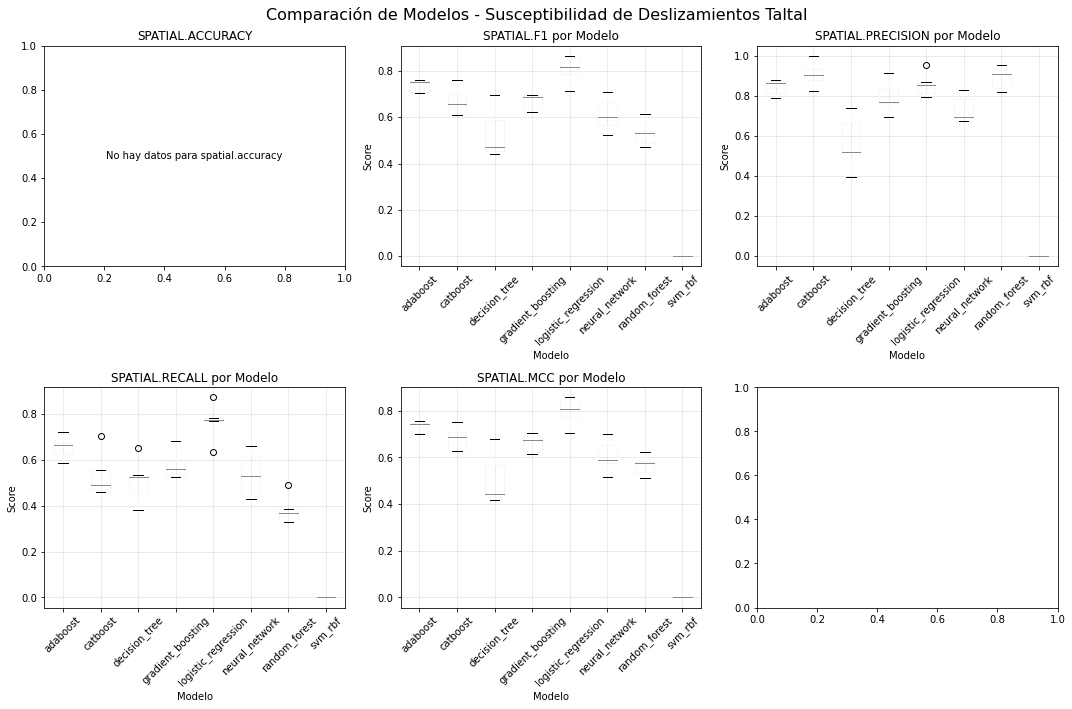

In [29]:
# Crear visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir resultados a DataFrame
df_results = result.to_dataframe()

# Configurar el estilo
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, measure in enumerate(['spatial.accuracy', 'spatial.f1', 'spatial.precision', 'spatial.recall', 'spatial.mcc']):
    ax = axes[idx]
    
    # Filtrar datos para esta medida
    df_measure = df_results[df_results['measure'] == measure].copy()
    
    if not df_measure.empty:
        # Boxplot
        df_pivot = df_measure.pivot_table(
            values='score',
            index='iteration',
            columns='learner'
        )
        
        df_pivot.boxplot(ax=ax, rot=45)
        ax.set_title(f'{measure.upper()} por Modelo')
        ax.set_xlabel('Modelo')
        ax.set_ylabel('Score')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, f'No hay datos para {measure}',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{measure.upper()}')

plt.suptitle('Comparación de Modelos - Susceptibilidad de Deslizamientos Taltal', fontsize=16)
plt.tight_layout()
plt.show()


Matriz de correlación entre métricas:


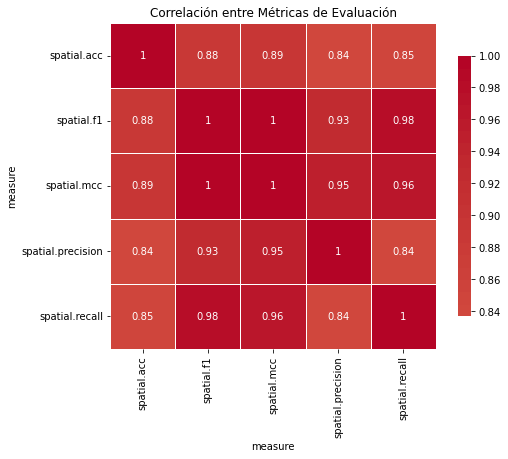


Mejor modelo por métrica:
  spatial.acc: logistic_regression (0.9792)
  spatial.f1: logistic_regression (0.8071)
  spatial.mcc: logistic_regression (0.7989)
  spatial.precision: catboost (0.9098)
  spatial.recall: logistic_regression (0.7659)


In [30]:
# Matriz de correlación entre métricas
print("\nMatriz de correlación entre métricas:")

# Agregar scores por learner y medida
agg_scores = result.aggregate(
    group_by=['learner', 'measure'],
    aggr_func='mean'
)

if not agg_scores.empty:
    # Pivotear para tener métricas como columnas
    pivot_scores = agg_scores.pivot_table(
        values='score',
        index='learner',
        columns='measure'
    )
    
    # Calcular correlación
    corr_matrix = pivot_scores.corr()
    
    # Visualizar
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlación entre Métricas de Evaluación')
    plt.show()
    
    # Mostrar mejores modelos
    print("\nMejor modelo por métrica:")
    for col in pivot_scores.columns:
        best_model = pivot_scores[col].idxmax()
        best_score = pivot_scores[col].max()
        print(f"  {col}: {best_model} ({best_score:.4f})")

## Exportación de Resultados

In [ ]:
# Guardar resultados
output_dir = "resultados_taltal"
os.makedirs(output_dir, exist_ok=True)

# 1. Guardar rankings
for measure in ['accuracy', 'auc', 'f1']:
    rankings = result.rank_learners(measure)
    if not rankings.empty:
        rankings.to_csv(f"{output_dir}/rankings_{measure}.csv")
        print(f"Rankings de {measure} guardados")

# 2. Guardar todos los scores
df_all_scores = result.to_dataframe()
df_all_scores.to_csv(f"{output_dir}/all_scores.csv", index=False)
print(f"Todos los scores guardados")

# 3. Guardar resumen
with open(f"{output_dir}/summary.txt", 'w') as f:
    f.write(result.summary())
print(f"Resumen guardado")

# 4. Guardar objeto completo de resultados
result.save(f"{output_dir}/benchmark_result.pkl")
print(f"Objeto de resultados guardado")

print(f"\nTodos los resultados guardados en: {os.path.abspath(output_dir)}")

## Conclusiones y Próximos Pasos

### Resumen del Análisis
1. **Datos**: Dataset sintético de 5000 muestras con características geoespaciales
2. **Selección de características**: Métodos de información mutua y Relief
3. **Validación espacial**: K-fold espacial para evitar autocorrelación
4. **Modelos comparados**: Múltiples algoritmos de ML incluyendo ensemble methods
5. **Evaluación**: Múltiples métricas con análisis estadístico

### Próximos Pasos
1. **Datos reales**: Integrar DEM y datos de inventario real de Taltal
2. **Más características**: Agregar índices espectrales de imágenes satelitales
3. **Optimización**: Ajuste de hiperparámetros con Optuna o GridSearch
4. **Mapeo**: Generar mapa de susceptibilidad con el mejor modelo
5. **Validación**: Comparar con inventarios históricos

### Integración con R
- Los resultados pueden exportarse para análisis adicional en R
- El modelo entrenado puede usarse para predicción en nuevas áreas
- La validación cruzada espacial asegura robustez geográfica

In [31]:
# Información del sistema
import platform
print("\nInformación del Sistema:")
print(f"Python: {platform.python_version()}")
print(f"Sistema: {platform.system()} {platform.release()}")

# Verificar ubicación de MLPY
import mlpy
print(f"MLPY instalado en: {mlpy.__file__}")

# Versiones de librerías principales
import sklearn
print(f"\nVersiones de librerías:")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")

try:
    import xgboost
    print(f"XGBoost: {xgboost.__version__}")
except:
    print("XGBoost: No instalado")

try:
    import lightgbm
    print(f"LightGBM: {lightgbm.__version__}")
except:
    print("LightGBM: No instalado")

try:
    import catboost
    print(f"CatBoost: {catboost.__version__}")
except:
    print("CatBoost: No instalado")


Información del Sistema:
Python: 3.9.12
Sistema: Windows 10
MLPY instalado en: C:\Users\gran_\Documents\Proyectos\MLPY\mlpy\__init__.py

Versiones de librerías:
NumPy: 1.26.4
Pandas: 2.2.2
Scikit-learn: 1.0.2
XGBoost: 2.1.4
LightGBM: 4.6.0
CatBoost: 1.2.8
